In [1]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
import scipy.signal as signal
import seaborn as sns
import anndata as an
import scanpy as sc

sys.path.append('../src/')
from graphene_electro_seq_analysis.ephy import *


/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '../SourceData/Figure2/'

# Load and filter traces

In [3]:
# Load rhd file and process
'''
# on driver
recording_dates = ['220922', '220926', '220929', '221004','221009']


channel_indices = [[48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78],
                   [80, 82, 84, 86, 88, 90, 92, 94, 32, 34, 36, 38, 40, 42, 44, 46],
                   [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                   [79, 77, 75, 73, 71, 69, 67, 65, 63, 61, 59, 57, 55, 53, 51, 49],
                   [16 ,18 ,20 ,22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46]]

data_path = './2022_Device1_Sample2/'
output_path = './2022_Device1_Sample2/results/'  

filtered_and_smoothed_traces = process_rhd_files_longitudinal(recording_dates, channel_indices, data_path, output_path)
'''

"\n# on driver\nrecording_dates = ['220922', '220926', '220929', '221004','221009']\n\n\nchannel_indices = [[48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78],\n                   [80, 82, 84, 86, 88, 90, 92, 94, 32, 34, 36, 38, 40, 42, 44, 46],\n                   [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],\n                   [79, 77, 75, 73, 71, 69, 67, 65, 63, 61, 59, 57, 55, 53, 51, 49],\n                   [16 ,18 ,20 ,22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46]]\n\ndata_path = './2022_Device1_Sample2/'\noutput_path = './2022_Device1_Sample2/results/'  \n\nfiltered_and_smoothed_traces = process_rhd_files_longitudinal(recording_dates, channel_indices, data_path, output_path)\n"

# Plot raw traces (Figure 2e)

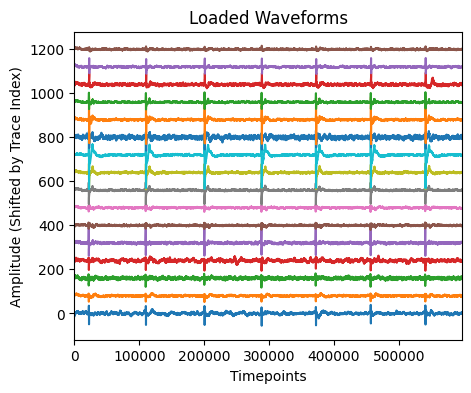

In [4]:
# Load the saved source data (.npy or .npz file)
loaded_data = np.load(data_path+"Figure2e_waveforms.npy")

# Plot the loaded waveforms
plt.figure(figsize=(5, 4))

gap = 80  # Adjust for visualization
for trace_index, trace in enumerate(loaded_data):
    plt.plot(trace + trace_index * gap)

plt.xlim(0, loaded_data.shape[1])  # Set x-axis limits based on loaded data
plt.xlabel("Timepoints")
plt.ylabel("Amplitude (Shifted by Trace Index)")
plt.title("Loaded Waveforms")

plt.show()


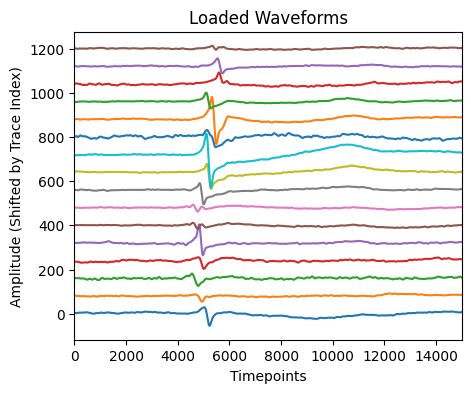

In [5]:
# Load the saved source data (.npy or .npz file)
loaded_data = np.load(data_path+"Figure2e_waveforms_zoomin.npy")

# Plot the loaded waveforms
plt.figure(figsize=(5, 4))

gap = 80  # Adjust for visualization
for trace_index, trace in enumerate(loaded_data):
    plt.plot(trace + trace_index * gap)

plt.xlim(0, loaded_data.shape[1])  # Set x-axis limits based on loaded data
plt.xlabel("Timepoints")
plt.ylabel("Amplitude (Shifted by Trace Index)")
plt.title("Loaded Waveforms")

plt.show()


# Plot mean and std waveforms (Figure 2f)

## Load Processed Anndata

In [6]:
an_spks_all = sc.read_h5ad(data_path+'Figure2_all_spikes.h5ad')
an_spks_all.obs_names_make_unique()

an_spks_mean = sc.read_h5ad(data_path+'Figure2_mean_spikes.h5ad')
an_spks_mean.obs_names_make_unique()

/var/folders/qc/my6pktfj2x37y67dq8r1g28c0000gn/T/ipykernel_4153/4152435908.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', 10)


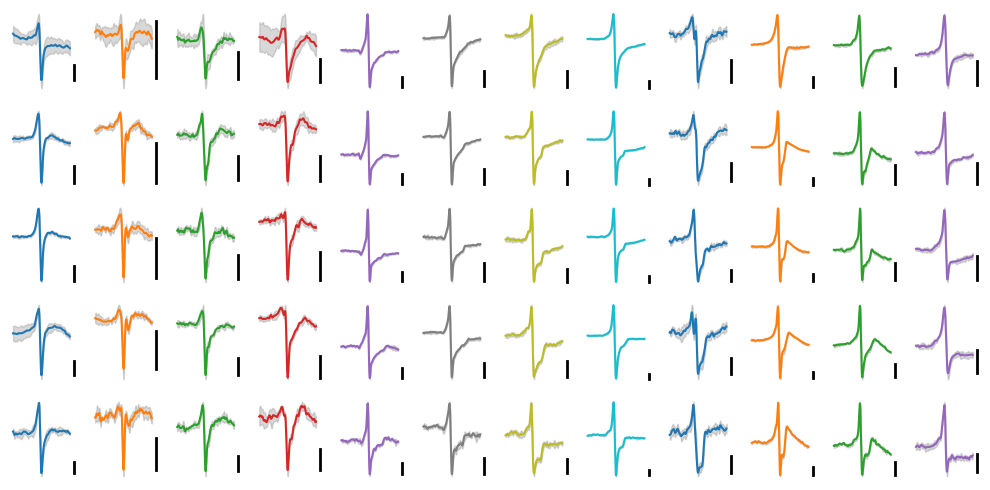

In [7]:
# Extract data and metadata
waveforms = an_spks_all.X[:, 4000:8000]  # Slice to use only the partial waveform segment [4000:8000]
channels = an_spks_all.obs['channels']  # Channel labels
stages = an_spks_all.obs['stages']  # Recording dates

# Unique channels and recording dates
unique_channels = channels.unique()
unique_dates = stages.unique()

# Create a color map using tab10 and assign colors to original channels from 0 to 15
cmap = cm.get_cmap('tab10', 10)
original_channel_indices = list(range(16))  # Original indices from 0 to 15
channel_colors = {f'ch{ch}': cmap(i % 10) for i, ch in enumerate(original_channel_indices)}  # Mapping all original channels

# Define the scale bar height in amplitude units
amplitude_bar_height = 20  # Adjust based on the scale of your data

# Initialize a figure with dates as rows and channels as columns
fig, axes = plt.subplots(len(unique_dates), len(unique_channels), figsize=(10, 5), sharex=True)

# Iterate over each recording date and channel
for i, date in enumerate(unique_dates):
    for j, channel in enumerate(unique_channels):
        # Filter data for the specific date and channel
        mask = (channels == channel) & (stages == date)
        channel_waveforms = waveforms[mask, :]  # Apply the mask on the partial waveform data

        # Calculate mean and standard deviation across waveforms
        mean_waveform = np.mean(channel_waveforms, axis=0)
        std_waveform = np.std(channel_waveforms, axis=0)

        # Plotting
        ax = axes[i, j]
        time_axis = np.arange(mean_waveform.shape[0])  # Adjust time axis based on the partial segment length

        # Use the color assigned to the specific channel based on the original plot
        ax.plot(time_axis, mean_waveform, color=channel_colors.get(channel, "black"), label=f'{date} {channel}')
        ax.fill_between(time_axis, mean_waveform - std_waveform, mean_waveform + std_waveform, color='gray', alpha=0.3)

        # Remove borders
        ax.axis('off')

        # Add y-axis scale bar on the right side of each subplot
        y_position = mean_waveform.min()  # Position the scale bar at the minimum of the mean waveform
        ax.plot([time_axis[-1] + 300, time_axis[-1] + 300], [y_position, y_position + amplitude_bar_height], color="black", lw=2)

plt.tight_layout()
plt.show()


## Or load source data

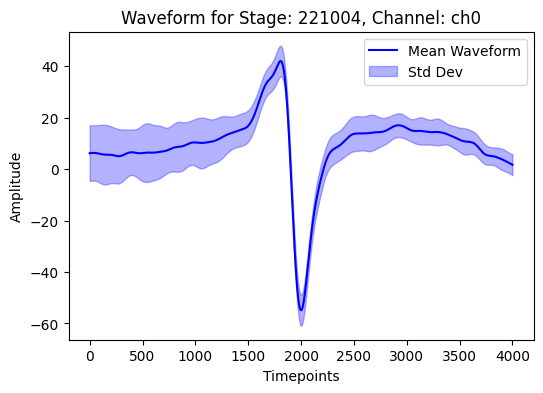

In [8]:
# Load the saved .npz file
loaded_data = np.load(data_path+"Figure2f_longterm_waveforms.npz", allow_pickle=True)

# Extract stored arrays
mean_waveforms = loaded_data["mean_waveforms"].item()  # Convert back to dictionary
std_waveforms = loaded_data["std_waveforms"].item()  # Convert back to dictionary
stages = loaded_data["stages"]
channels = loaded_data["channels"]

# Select a specific stage and channel for plotting (use the first available ones)
stage = stages[3]
channel = channels[0]

# Get mean and std waveforms
mean_wave = mean_waveforms[stage][channel]
std_wave = std_waveforms[stage][channel]

# Plot mean waveform with standard deviation as shaded region
timepoints = np.arange(len(mean_wave))  # Generate time indices

plt.figure(figsize=(6, 4))
plt.plot(timepoints, mean_wave, label="Mean Waveform", color='b')
plt.fill_between(timepoints, mean_wave - std_wave, mean_wave + std_wave, color='b', alpha=0.3, label="Std Dev")

plt.xlabel("Timepoints")
plt.ylabel("Amplitude")
plt.title(f"Waveform for Stage: {stage}, Channel: {channel}")
plt.legend()
plt.show()